# Environment Init

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
import torch
from sklearn.metrics import r2_score, root_mean_squared_error

from torch.utils.data import DataLoader, Dataset

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Dataset Import

In [2]:
folder = os.path.join("..", "Datasets", "F16") 
f_train_ds =  os.path.join(folder, "F16Data_SineSw_Level3.csv")
f_test_ds = os.path.join(folder, "F16Data_SineSw_Level4_Validation.csv")

# create dictionary with training and test dataset
dict_ds = {"train": [], "test": [],}
dict_ds["train"] = pd.read_csv(f_train_ds) 
dict_ds["test"] = pd.read_csv(f_test_ds)

# data normalization
ds_mean = dict_ds["train"].mean() 
ds_std = dict_ds["train"].std()
dict_ds["train"]  = (dict_ds["train"] - ds_mean)/ds_std
dict_ds["test"]  = (dict_ds["test"] - ds_mean)/ds_std

In [3]:
ind_out = 0  # output index (0 or 1 or 2)
na = 5  # output lag
nb = 20  # input lag

class F16DS(Dataset):
  def __init__(self, pd_file: pd.DataFrame, na, nb):
    output_names = ["Acceleration1", "Acceleration2", "Acceleration3"]
    self.pd_file = pd_file  # pandas dataset
    self.na = na
    self.nb = nb

    n = max(na, nb)
    b_idx = np.arange(n, len(pd_file))[:, None] - np.arange(nb)[None, :]
    a_idx = np.arange(n, len(pd_file))[:, None] - np.arange(1, na)[None, :]

    self.regressor = torch.from_numpy(np.hstack([
        pd_file["Force"].to_numpy()[b_idx],
        pd_file["Voltage"].to_numpy()[b_idx],
        pd_file["Acceleration1"].to_numpy()[a_idx],
        pd_file["Acceleration2"].to_numpy()[a_idx],
        pd_file["Acceleration3"].to_numpy()[a_idx]
    ])).float()

    self.out = torch.from_numpy(
        pd_file.loc[n:, ["Acceleration1",
                         "Acceleration2",
                         "Acceleration3"]].values).float()

  def __len__(self):
    return self.out.shape[0]

  def __getitem__(self, idx):
    x = self.regressor[idx, :]
    y = self.out[idx, :]

    return x, y

F16DS_train = F16DS(pd_file = dict_ds["train"], na = na, nb = nb)
F16DS_test = F16DS(pd_file = dict_ds["test"], na = na, nb = nb)

# access elements of the datasets. Example
idx = 10  # sample index
x, y = F16DS_train[idx]

print(f"Training: regressor at step {idx}: {x} \n")
print(f"Training: output at step {idx}: {y} \n")

Training: regressor at step 10: tensor([-4.0133e-03,  3.9508e-04,  1.0225e-03,  8.7239e-04,  4.1384e-03,
        -5.5150e-04, -8.1693e-04, -8.7056e-04, -4.4369e-03,  1.4034e-04,
         9.1528e-04,  6.8470e-04,  3.7040e-03, -8.2230e-04, -9.5640e-04,
        -8.1961e-04, -4.4101e-03,  2.2347e-04,  8.1070e-04,  3.7631e-04,
         2.9666e-04,  4.7372e-04,  5.9176e-04,  3.5567e-04,  2.9666e-04,
         6.5077e-04,  3.5567e-04,  3.5567e-04,  2.9666e-04,  2.9666e-04,
         3.2617e-04,  1.7861e-04,  2.3763e-04,  2.9666e-04,  3.5567e-04,
        -5.7473e-05,  1.7861e-04, -1.4601e-04,  2.0812e-04,  4.4422e-04,
        -4.1637e-03,  1.4640e-02, -1.1820e-04, -8.2093e-03, -2.0449e-03,
        -1.2507e-04,  6.0053e-03,  3.2782e-03,  8.7099e-03,  9.3137e-04,
         2.3414e-03,  1.1429e-03]) 

Training: output at step 10: tensor([ 0.0149,  0.0007, -0.0011]) 



In [4]:
# create and test a dataloader of batch size
loader_train = DataLoader(F16DS_train, shuffle=True,
                          batch_size=256)  # define data loader

# see one batch of the dataloader
x, y = next(iter(loader_train))
print(f"size of the regressor: {x.shape};  size of the output: {y.shape}")

size of the regressor: torch.Size([256, 52]);  size of the output: torch.Size([256, 3])


# Feed-Forward Network

In [5]:
class FeedforwardNeuralNetwork(keras.Model):
  def __init__(self, hidden_sizes, output_size):
    super(FeedforwardNeuralNetwork, self).__init__()
    self.hidden_size = hidden_sizes
    self.output_size = output_size

    self.hidden_layers = [keras.layers.Dense(hs, activation="sigmoid")
                          for hs in hidden_sizes]
    self.output_layer = keras.layers.Dense(output_size)
  
  def call(self, inputs):
    x = inputs
    for hl in self.hidden_layers:
      x = hl(x)
    
    return self.output_layer(x)

net = FeedforwardNeuralNetwork(hidden_sizes=[5, 30, 20], output_size=3)

In [6]:
net.compile(keras.optimizers.Adam(1e-3), loss="mse")
net(keras.Input(F16DS_train.regressor.shape[1:]))
net.fit(x=loader_train, epochs=64, callbacks=[keras.callbacks.EarlyStopping("loss", patience=16)])

Epoch 1/64
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.0525
Epoch 2/64
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.3609
Epoch 3/64
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1607
Epoch 4/64
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0902
Epoch 5/64
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0595
Epoch 6/64
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0448
Epoch 7/64
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0344
Epoch 8/64
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0280
Epoch 9/64
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0259
Epoch 10/64
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0221
Epoch 11/64
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0211
Epoch 12/64
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0200
Epoch 13/64
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0199
Epoch 14/64
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0189
Epoch 15/64
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 10m

## One-Step Performance

 12/456 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step

456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
RMSE: 0.2627239525318146
R2: 0.9702766249772411


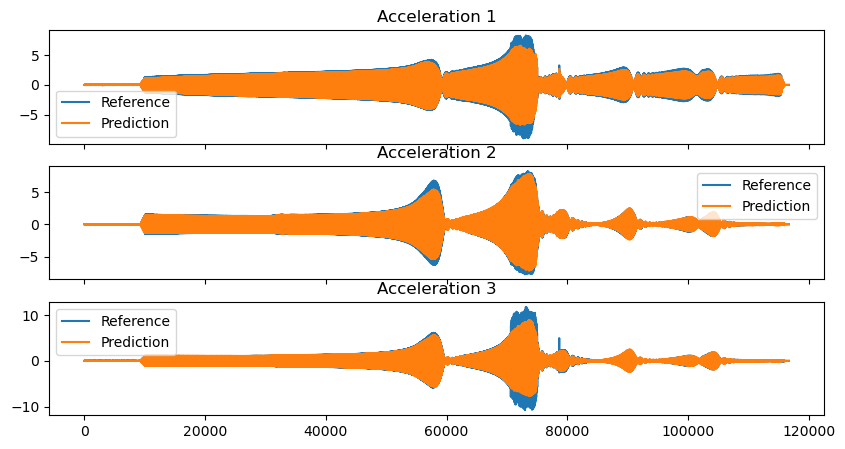

In [7]:
loader_test = DataLoader(F16DS_test, shuffle=False,
                         batch_size=256)
y_true = F16DS_test.out.numpy()
y_pred = net.predict(loader_test)

fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10,5))

for idx in range(3):
  ax[idx].plot(y_true[:,idx], label="Reference")
  ax[idx].plot(y_pred[:,idx], label="Prediction")
  ax[idx].legend()
  ax[idx].set_title(f"Acceleration {idx+1}")

print(f"RMSE: {root_mean_squared_error(y_true, y_pred)}")
print(f"R2: {r2_score(y_true, y_pred)}")

## Simulation Performance

     0/116716 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/sample

116716/116716 ━━━━━━━━━━━━━━━━━━━━ 246s 2ms/sample
RMSE: 7.511606216430664
R2: -25.78513244734116


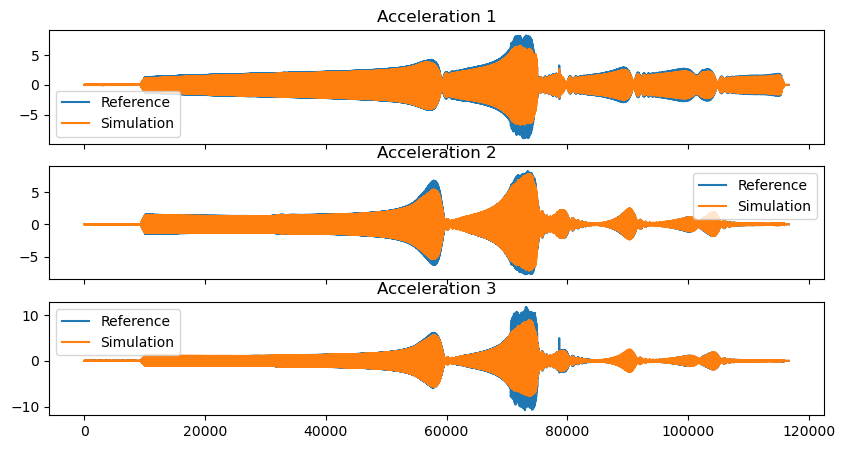

In [8]:
def simulate(network: keras.Functional, dataset: F16DS) -> np.ndarray:
  x = dataset.regressor.numpy()
  y = np.zeros([x.shape[0], 3], dtype=np.float32)

  progbar = keras.utils.Progbar(x.shape[0], unit_name="sample")

  if dataset.na > 0:
    x[1:, -3 * dataset.na] = 0

  for idx in range(x.shape[0] - 1):
    y[idx, :] = network.predict(x[None, idx - 1, :], verbose=0)
    progbar.update(idx)

    if dataset.na > 1:
      x[idx + 1, -(dataset.na - 1) * 3:] = x[idx, -dataset.na * 3:-3]
    if dataset.na > 0:
      x[idx + 1, -dataset.na * 3:-(dataset.na - 1) * 3] = y[idx, :]

  y[-1, :] = network.predict(x[None, -1, :], verbose=0)
  progbar.update(y.shape[0])

  return y


y_sim = simulate(net, F16DS_test)

fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10,5))

for idx in range(3):
  ax[idx].plot(y_true[:,idx], label="Reference")
  ax[idx].plot(y_pred[:,idx], label="Simulation")
  ax[idx].legend()
  ax[idx].set_title(f"Acceleration {idx+1}")

print(f"RMSE: {root_mean_squared_error(y_true, y_sim)}")
print(f"R2: {r2_score(y_true, y_sim)}")

# LSTM

In [9]:
class F16DS_seq(Dataset):
  def __init__(self, pd_file, seq_len):
    output_names = [f"Acceleration{idx + 1}" for idx in range(3)]
    self.pd_file = pd_file  # pandas dataset
    self.seq_len = seq_len

    n_samples = len(pd_file)
    n = int(np.floor(len(pd_file) / seq_len))

    adv_idx = np.arange(n * seq_len).reshape([n, seq_len])

    u = np.stack([pd_file["Force"].to_numpy()[adv_idx],
                  pd_file["Voltage"].to_numpy()[adv_idx]], axis=-1)

    y = np.stack([pd_file[variable].to_numpy()[adv_idx]
                  for variable in output_names], axis=-1)

    self.u = torch.from_numpy(u).float()
    self.y = torch.from_numpy(y).float()

  def __len__(self):
    return self.y.shape[0]

  def __getitem__(self, idx):
    u = self.u[idx, :, :]
    y = self.y[idx, :, :]

    return u, y

In [10]:
input_size = 2
seq_len = 2000 # Length of the training sub-sequences
batch_size = 10 # batch size for the data loader

folder = os.path.join("..", "Datasets", "F16")
f_train_ds =  os.path.join(folder, "F16Data_SineSw_Level3.csv")
f_test_ds = os.path.join(folder, "F16Data_SineSw_Level4_Validation.csv")


dict_ds = {"train": [], "test": [],}
dict_ds["train"] = pd.read_csv(f_train_ds) 
dict_ds["test"] = pd.read_csv(f_test_ds)


ds_mean = dict_ds["train"].mean() 
ds_std = dict_ds["train"].std()
dict_ds["train"]  = (dict_ds["train"] - ds_mean)/ds_std
dict_ds["test"]  = (dict_ds["test"] - ds_mean)/ds_std


# Create instance of the class F16DS_seq and plot shape of inputs and outputs
F16DS_train = F16DS_seq(pd_file=dict_ds["train"], seq_len = seq_len)
loader_train = DataLoader(F16DS_train, shuffle=True, batch_size=batch_size)
u, y = next(iter(loader_train))

print(f"u shape: {u.shape}; y shape: {y.shape}")

u shape: torch.Size([10, 2000, 2]); y shape: torch.Size([10, 2000, 3])


In [11]:
class LSTMNet(keras.Model):
  def __init__(self, hidden_size, output_size, num_layers):
    super(LSTMNet, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    

    # Define the LSTM layer
    self.lstm_layers = [keras.layers.LSTM(hidden_size,
                                          return_sequences=True,
                                          return_state=False)
                        for _ in range(num_layers)]

    # Define the output layer
    self.fc = keras.layers.Dense(output_size)

  def call(self, inputs):
    x = inputs

    for layer in self.lstm_layers:
      x = layer(x)

    return self.fc(x)

In [12]:
lstm_net = LSTMNet(hidden_size=20, num_layers=2,
                    output_size=F16DS_train.y.shape[-1])
lstm_net.compile(keras.optimizers.Adam(1e-3), loss="mse")
lstm_net.summary()
lstm_net.fit(x=loader_train, epochs=64, callbacks=[
             keras.callbacks.EarlyStopping("loss", patience=16)])

Model: "lstm_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/64
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - loss: 0.8848
Epoch 2/64
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - loss: 1.2321
Epoch 3/64
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - loss: 0.8148
Epoch 4/64
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - loss: 0.9975
Epoch 5/64
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - loss: 1.3597
Epoch 6/64
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - loss: 0.5709
Epoch 7/64
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - loss: 0.6662
Epoch 8/64
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - loss: 0.9017
Epoch 9/64
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - loss: 0.8022
Epoch 10/64
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - loss: 0.9625
Epoch 11/64
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - loss: 0.7433
Epoch 12/64
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - loss: 0.5350
Epoch 13/64
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - loss: 0.7524
Epoch 14/64
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - loss: 0.4687
Epoch 15/64
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - loss: 0.5895
Epoch 16/64
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step 

6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
RMSE: 0.9883632659912109
R2: 0.5920975625420132


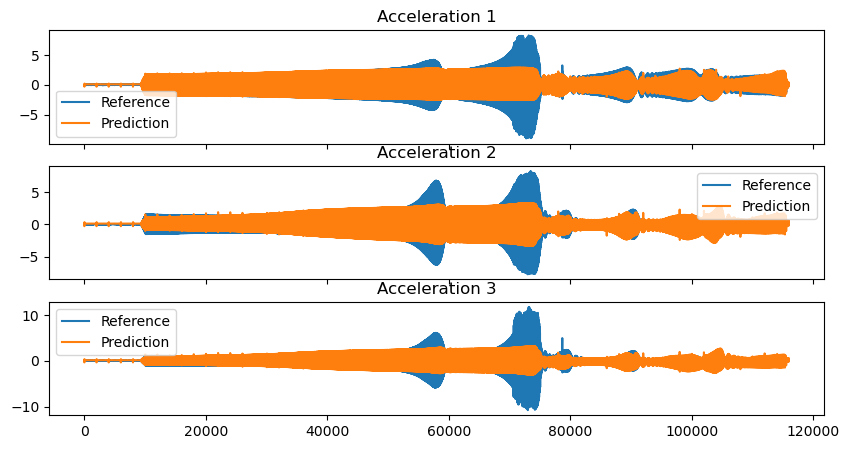

In [13]:
F16DS_test = F16DS_seq(pd_file=dict_ds["test"], seq_len=seq_len)
loader_test = DataLoader(F16DS_test, shuffle=False,
                         batch_size=10)
y_true = F16DS_test.y.numpy()
y_pred = lstm_net.predict(loader_test)

fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 5))

for idx in range(3):
  ax[idx].plot(y_true[..., idx].reshape(-1), label="Reference")
  ax[idx].plot(y_pred[..., idx].reshape(-1), label="Prediction")
  ax[idx].legend()
  ax[idx].set_title(f"Acceleration {idx + 1}")

print(f"RMSE: {root_mean_squared_error(y_true.reshape([-1, 3]),
                                       y_pred.reshape([-1, 3]))}")
print(f"R2: {r2_score(y_true.reshape([-1, 3]),
                      y_pred.reshape([-1, 3]))}")